## 实现方式
- 加入新的特征属性

# 构建新的特征属性
基于现有的原始特征属性，结合业务特征，引入一些衍生变量。具体的常见金融指标可以参考书籍:《[股市技术指标实战:原理、方法、技巧与实践](https://www.amazon.cn/dp/B00W413L4A/ref=tmm_pap_swatch_0?_encoding=UTF8&qid=1544412214&sr=8-4-fkmr3)》；常见的衍生变量如下：
- 移动平均线MA
- 指数平滑异动平均线MACD
- 平均线差DMA
- 三重指数平滑指标TRIX
- 趋向指标DMI
- 多空指标BBI
- 动量指标MTM
- 瀑布线PBX
- 人气意愿指标ARBR
- 中间意愿指标CR
- 随机摆动指标KDJ
- 相对强弱指标RSI
- 威廉指标W%R
- 乖离率指标BIAS
- 顺势指标CCI
- 心理线PSY
- 变动率指标ROC
- 短线盈亏指标CY
- 终极指标UOS
- 均量线MAVOL
- 量指数平滑异同移动平均线VMACD
- 量相对强弱指标VRSI
- 能量潮OBV
- 均笔成交MBSS

我们这里仅仅引入MA以及MACD之类的指标

### talib的安装方式
- 从 https://www.lfd.uci.edu/~gohlke/pythonlibs/ 下载对应版本的[TA_Lib](http://ta-lib.org/)
- 使用pip安装whl文件，eg: pip install D:\TA_Lib‑0.4.17‑cp36‑cp36m‑win_amd64.whl

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn import svm
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
import talib as ta

In [2]:
np.random.seed(28)

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

In [5]:
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [6]:
stockcode = '000001.SZ'
stockname = '平安银行'
file_path = './data/000001.SZ_day_qfq.csv'
stockfile = pd.read_csv(file_path, index_col='trade_date', parse_dates=True)

In [7]:
def calc_profit(data, position_period=5):
    """
    计算持仓收益，并给定标签
    """
    price = data['close']
    data['profit'] = (data['close'].shift(-position_period) - price) / price * 100.0
    data['label'] = 0
    data.loc[data['profit'] > 1.0, 'label'] = 1

In [8]:
# 计算收益并给定标签
calc_profit(stockfile)

In [9]:
def candle_stick(axes, xindex, data, colorup='red', colordown='green'):
    """
        绘制K线
        axes: 绘制图像的pylot对象
        xindex: 索引
        data: 数据DataFrame，要求具有close、open、high、low这四个属性
    """
    up = data['close'] >= data['open']
    down = data['close'] < data['open']
    
    if any(up):
        axes.vlines(xindex[up], data['open'][up], data['close'][up], color=colorup, linewidth=5.5)
        axes.vlines(xindex[up], data['low'][up], data['high'][up], color=colorup, linewidth=1)
    
    if any(down):
        axes.vlines(xindex[down], data['open'][down], data['close'][down], color=colordown, linewidth=5.5)
        axes.vlines(xindex[down], data['low'][down], data['high'][down], color=colordown, linewidth=1)

#### 加入移动均线指标

In [10]:
def ema(df, m1=5, m2=10, m3=20):
    price = df['close']
    df['ma1'] = ta.EMA(price, m1)
    df['ma2'] = ta.EMA(price, m2)
    df['ma3'] = ta.EMA(price, m3)
    df['macross'] = df['ma1'] - df['ma2']

In [11]:
# 加入指数均线
ema(stockfile)

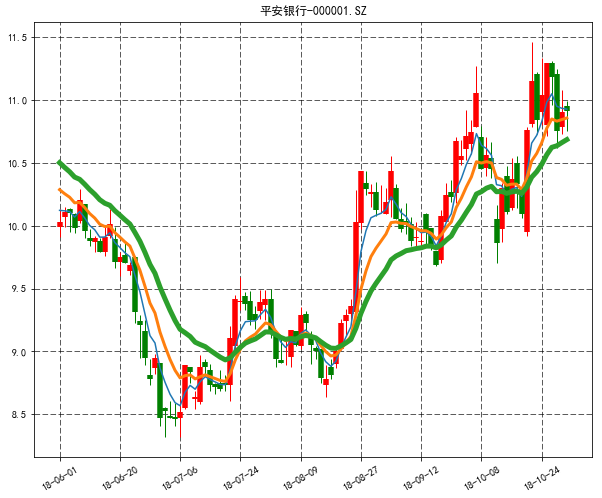

In [12]:
df = stockfile['2018-06-01':]

plt.figure(figsize=(10,8))
axes = plt.gca()
xindex = np.arange(len(df))
candle_stick(axes, xindex, df)
plt.plot(xindex, df['ma1'])
plt.plot(xindex, df['ma2'], linewidth=3)
plt.plot(xindex, df['ma3'], linewidth=5)
# 给定标签
dates = np.array(df.index.to_pydatetime())
sdates = [date.strftime('%y-%m-%d') for date in dates]
step = len(xindex) // 8
axes.set_xticks(xindex[::step])
axes.set_xticklabels(sdates[::step], rotation=30)
# 画网格
axes.grid(True, ls='--', alpha=0.8, color='k')
plt.title('{}-{}'.format(stockname, stockcode))
plt.show()

### 图形分析
从上述图形中可以发现以下几个特征：
- 当m1增大的时候，很大几率是涨的情况；当m1减小的时候，很大几率是跌的情况
- 当m2比m1大的时候，很大几率处于下跌状态；当m2比m1小的时候，很大几率处于上涨的情况
- 当m3比m2大的时候，大方向处于下跌状态；当m3比m2小的时候，大方向处于上涨的情况

In [13]:
stockfile['_ma1'] = np.insert(np.diff(stockfile['ma1']), 0, 0)
stockfile['_ma2'] = stockfile['_ma1'].apply(lambda x: 1.0 if x > 0 else 0.0)
stockfile['_ma3'] = (stockfile['ma1'] < stockfile['ma2']).astype(np.float)
stockfile['_ma4'] = (stockfile['ma2'] < stockfile['ma3']).astype(np.float)

#### 加入MACD指标

In [14]:
def macd(df):
    res = ta.MACD(df['close'])
    df['dif'] = res[0]
    df['dea'] = res[1]
    df['macd'] = res[2]
    df['macdcross'] = df['dif'] - df['dea']

In [15]:
# 加入指数平滑异动平均线
macd(stockfile)

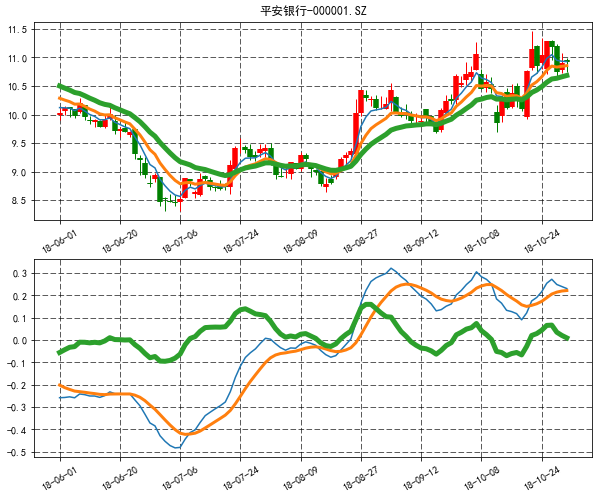

In [16]:
df = stockfile['2018-06-01':]
xindex = np.arange(len(df))

plt.figure(figsize=(10,8))

axes = plt.subplot(2,1,1)
candle_stick(axes, xindex, df)
plt.plot(xindex, df['ma1'])
plt.plot(xindex, df['ma2'], linewidth=3)
plt.plot(xindex, df['ma3'], linewidth=5)
# 给定标签
dates = np.array(df.index.to_pydatetime())
sdates = [date.strftime('%y-%m-%d') for date in dates]
step = len(xindex) // 8
axes.set_xticks(xindex[::step])
axes.set_xticklabels(sdates[::step], rotation=30)
# 画网格
axes.grid(True, ls='--', alpha=0.8, color='k')
plt.title('{}-{}'.format(stockname, stockcode))

axes2 = plt.subplot(2,1,2, sharex=axes)
plt.plot(xindex, df['dif'])
plt.plot(xindex, df['dea'], linewidth=3)
plt.plot(xindex, df['macd'], linewidth=5)

# 给定标签
dates = np.array(df.index.to_pydatetime())
sdates = [date.strftime('%y-%m-%d') for date in dates]
step = len(xindex) // 8
axes2.set_xticks(xindex[::step])
axes2.set_xticklabels(sdates[::step], rotation=30)
# 画网格
axes2.grid(True, ls='--', alpha=0.8, color='k')

plt.show()

### 图形分析
从上述图形中可以发现以下几个特征：
- 当macd为正数的时候，有很大几率处于上涨状态
- 当macd处于增大数值的时候，有很大几率处于上涨状态

In [17]:
stockfile['_macd1'] = np.insert(np.diff(stockfile['macd']), 0, 0)
stockfile['_macd2'] = stockfile['macd'].apply(lambda x: 1.0 if x > 0 else 0.0)

In [18]:
stockfile.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2551 entries, 2008-01-02 to 2018-10-31
Data columns (total 25 columns):
open          2551 non-null float64
high          2551 non-null float64
low           2551 non-null float64
close         2551 non-null float64
pre_close     2551 non-null float64
change        2551 non-null float64
pct_change    2551 non-null float64
vol           2551 non-null float64
amount        2551 non-null float64
profit        2546 non-null float64
label         2551 non-null int64
ma1           2547 non-null float64
ma2           2542 non-null float64
ma3           2532 non-null float64
macross       2542 non-null float64
_ma1          2547 non-null float64
_ma2          2551 non-null float64
_ma3          2551 non-null float64
_ma4          2551 non-null float64
dif           2518 non-null float64
dea           2518 non-null float64
macd          2518 non-null float64
macdcross     2518 non-null float64
_macd1        2518 non-null float64
_macd2       

In [19]:
# 查看所有特征属性之间的相关性
corr = stockfile.corr()
corr.loc[:,:] = np.tril(corr, k=-1)
corr = corr.stack()
corr = corr[(corr > 0.5) | (corr < -0.5)]
corr

high        open          0.998200
low         open          0.998651
            high          0.997505
close       open          0.997121
            high          0.998778
            low           0.998336
pct_change  change        0.932152
vol         open          0.594773
            high          0.620646
            low           0.585415
            close         0.608256
amount      open          0.557333
            high          0.585513
            low           0.544733
            close         0.570341
            vol           0.951830
label       profit        0.715584
ma1         open          0.998307
            high          0.997533
            low           0.997739
            close         0.997331
            vol           0.591792
            amount        0.550850
ma2         open          0.995334
            high          0.993865
            low           0.994340
            close         0.993493
            vol           0.580797
            amount  

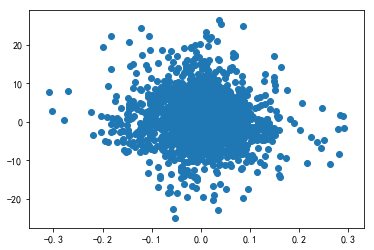

In [20]:
# 查看一下macdcross以及结果之间的关系
plt.scatter(stockfile['macdcross'], stockfile['profit'])

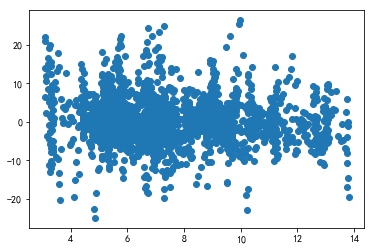

In [21]:
# 查看一下ma3以及结果之间的关系
plt.scatter(stockfile['ma3'], stockfile['profit'])

初始模型构建

* 获取特征属性和目标属性

In [22]:
stockfile.info()
stock_data = stockfile.drop(['open', 'high', 'low', 'pre_close',
                             'change', 'pct_change', 'vol', 'amount',
                             'profit','close'], axis=1)
stock_data.info()

split_idx = int(4.0 * stock_data.shape[0] / 5)
stock_train_data, stock_test_data = stock_data.iloc[:split_idx,:], stock_data.iloc[split_idx:, :]
print("训练数据格式:{}, 测试数据格式:{}".format(stock_train_data.shape, stock_test_data.shape))

# 获取收盘价
buy_price = stockfile['close']
train_data_buy_price = buy_price[:split_idx]
test_data_buy_price = buy_price[split_idx:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2551 entries, 2008-01-02 to 2018-10-31
Data columns (total 25 columns):
open          2551 non-null float64
high          2551 non-null float64
low           2551 non-null float64
close         2551 non-null float64
pre_close     2551 non-null float64
change        2551 non-null float64
pct_change    2551 non-null float64
vol           2551 non-null float64
amount        2551 non-null float64
profit        2546 non-null float64
label         2551 non-null int64
ma1           2547 non-null float64
ma2           2542 non-null float64
ma3           2532 non-null float64
macross       2542 non-null float64
_ma1          2547 non-null float64
_ma2          2551 non-null float64
_ma3          2551 non-null float64
_ma4          2551 non-null float64
dif           2518 non-null float64
dea           2518 non-null float64
macd          2518 non-null float64
macdcross     2518 non-null float64
_macd1        2518 non-null float64
_macd2       

* 数据分割

In [23]:
X = stock_data.drop('label', axis=1)
Y = stock_data['label']
x_train = stock_train_data.drop('label', axis=1)
x_test = stock_test_data.drop('label', axis=1)
y_train = stock_train_data['label']
y_test = stock_test_data['label']
print("训练数据格式:{}, 测试数据格式:{}".format(x_train.shape, x_test.shape))

训练数据格式:(2040, 14), 测试数据格式:(511, 14)


* 模型训练

In [24]:
imputer = preprocessing.Imputer()
x_train = imputer.fit_transform(x_train, y_train)
x_test = imputer.transform(x_test)
X = imputer.transform(X)

In [25]:
# scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
scaler = preprocessing.MinMaxScaler(feature_range=(-10,10))
x_train = scaler.fit_transform(x_train, y_train)
x_test = scaler.transform(x_test)
X = scaler.transform(X)

In [26]:
algo = svm.SVC(probability=True)
algo.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

* 模型效果评估

In [27]:
y_pred_test = algo.predict(x_test)
y_pred_train = algo.predict(x_train)
y_pred_all = algo.predict(X)
print("训练数据准确率:{}".format(metrics.accuracy_score(y_train, y_pred_train)))
print("测试数据准确率:{}".format(metrics.accuracy_score(y_test, y_pred_test)))
print("训练数据的效果混淆矩阵:\n{}".format(metrics.confusion_matrix(y_train, y_pred_train)))
print("训练数据的效果report:\n{}".format(metrics.classification_report(y_train, y_pred_train)))
print("测试数据的效果混淆矩阵:\n{}".format(metrics.confusion_matrix(y_test, y_pred_test)))
print("测试数据的效果report:\n{}".format(metrics.classification_report(y_test, y_pred_test)))
print("所有数据准确率:{}".format(metrics.accuracy_score(Y, y_pred_all)))
print("所有数据的效果混淆矩阵:\n{}".format(metrics.confusion_matrix(Y, y_pred_all)))
print("所有数据的效果report:\n{}".format(metrics.classification_report(Y, y_pred_all)))


训练数据准确率:0.782843137254902
测试数据准确率:0.5949119373776908
训练数据的效果混淆矩阵:
[[1202   59]
 [ 384  395]]
训练数据的效果report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.84      1261
           1       0.87      0.51      0.64       779

   micro avg       0.78      0.78      0.78      2040
   macro avg       0.81      0.73      0.74      2040
weighted avg       0.80      0.78      0.77      2040

测试数据的效果混淆矩阵:
[[272  61]
 [146  32]]
测试数据的效果report:
              precision    recall  f1-score   support

           0       0.65      0.82      0.72       333
           1       0.34      0.18      0.24       178

   micro avg       0.59      0.59      0.59       511
   macro avg       0.50      0.50      0.48       511
weighted avg       0.54      0.59      0.55       511

所有数据准确率:0.7451979615836927
所有数据的效果混淆矩阵:
[[1474  120]
 [ 530  427]]
所有数据的效果report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      1

#### 计算在当前模型情况下的，最终效果

In [28]:
def calc_rate_of_return_by_state(buy_price, buy_infos, initial_capital=100000.0):
    """
    buy_infos: 购买信息，True表示购买，False表示卖出
    :param buy_price: 价格信息
    :param buy_infos:
    :param initial_capital: 初始资本
    :return:
    """
    # 资本
    capital = initial_capital
    # 持有的股本
    hold_equity = 0.0

    flag = False
    for idx, buy_flag in enumerate(buy_infos):
        if buy_flag:
            # 当需要进行购买操作的时候，两种情况：如果之前就是购买，那就继续持有；否则全部买入
            if not flag:
                # 买入
                hold_equity = 1.0 * capital / buy_price[idx]
                flag = True
                capital = 0.0
        else:
            # 当需要进行卖出操作的时候，两种情况：如果之前就是卖出, 那么继续不买入；否则卖出
            if flag:
                # 卖出
                flag = False
                capital = hold_equity * buy_price[idx]
                hold_equity = 0.0

    # 计算最终的金额以及收益率
    total_capital = capital + hold_equity * buy_price[-1]
    return total_capital, (total_capital - initial_capital) / initial_capital


In [29]:
print("所有数据上")
print("原始随机情况下:")
buy_infos = np.ones_like(buy_price, dtype=np.bool)
buy_infos[::5] = False
print(calc_rate_of_return_by_state(buy_price, buy_infos))
print("模型预测情况下:")
buy_infos = y_pred_all.astype(np.bool)
print(calc_rate_of_return_by_state(buy_price, buy_infos))

所有数据上
原始随机情况下:
(124615.43419521823, 0.2461543419521823)
模型预测情况下:
(9804552.207707329, 97.04552207707329)


In [30]:
print("训练数据上")
print("原始随机情况下:")
buy_infos = np.ones_like(train_data_buy_price, dtype=np.bool)
buy_infos[::5] = False
print(calc_rate_of_return_by_state(train_data_buy_price, buy_infos))
print("模型预测情况下:")
buy_infos = y_pred_train.astype(np.bool)
print(calc_rate_of_return_by_state(train_data_buy_price, buy_infos))

训练数据上
原始随机情况下:
(97989.39091047984, -0.02010609089520163)
模型预测情况下:
(8332599.708882896, 82.32599708882896)


In [31]:
print("测试数据上")
print("原始随机情况下:")
buy_infos = np.ones_like(test_data_buy_price, dtype=np.bool)
buy_infos[::5] = False
print(calc_rate_of_return_by_state(test_data_buy_price, buy_infos))
print("模型预测情况下:")
buy_infos = y_pred_test.astype(np.bool)
print(calc_rate_of_return_by_state(test_data_buy_price, buy_infos))

测试数据上
原始随机情况下:
(127315.7470851489, 0.27315747085148906)
模型预测情况下:
(117664.98512169335, 0.17664985121693347)
